In [1]:
import os
import coastalcf as clf
from esa_snappy import ProductIO, GPF
from esa_snappy import GPF, HashMap, jpy
import numpy as np

---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
//////////////////        PREPARACIÓN DE LOS DATOS        /////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [2]:
# --- 1. Define la región de interés (ROI) para el subconjunto y la ruta del producto.
# Si no existew substet colocar None
# x = y = width = height = None
#Inicio de la región de interés (ROI) en coordenadas de píxeles.
x=32
y = 14091
#Final de la región de interés (ROI) en coordenadas de píxeles.
width = 1355
height = 897
#x = y = width = height = None

# Defininir parámetros para el operador GLCM.
para = {'sourceBands': 'VH'}

# Path del Producto de Sentinel 1 y ouput de archivos.

sentinel_1_path = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C2_Data\2023\S1A_IW_GRDH_1SDV_20230607T130609_20230607T130634_048880_05E0CE_1909'
sentinel_id = clf.get_sentinel_fecha_id(sentinel_1_path)
output_directory = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio'
output_directorysh = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\shape'


---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------
///////////////// APLICACIÓN DE LOS PASOS DE PROCESAMIENTO ////////////////
---------------------------------------------------------------------------
***************************************************************************
---------------------------------------------------------------------------

In [3]:
# --- 1. Lectura de metadatos del producto Sentinel-1 ---
product = clf.readMetadata(sentinel_1_path, toPrint=True)  

# --- 2. Eliminación de ruido térmico : do_thermal_noise_removal [output]---
thermaremoved = clf.do_thermal_noise_removal(product)
if thermaremoved is None:
    raise RuntimeError("Thermal noise removal failed.")
print(f"Bands after ThermalNoiseRemoval: {list(thermaremoved.getBandNames())}")
#**************************************************************************
# --- 3. Calibración radiométrica : radiometricCalibration [calibrated] ---
calibrate = clf.radiometricCalibration(thermaremoved)
if calibrate is None:
    raise RuntimeError("Radiometric calibration failed.")
print(f"Bands after RadiometricCalibration: {list(calibrate.getBandNames())}")

# - Verificar las bandas después de la calibración
valid_bands = list(calibrate.getBandNames())
print(f" Bandas disponibles después de la calibración: {valid_bands}")

# - Asegurar que usamos solo las bandas que existen
subset_bands = [band for band in ['Sigma0_VH', 'Sigma0_VV', 'Beta0_VH', 'Beta0_VV'] if band in valid_bands]
if not subset_bands:
    raise RuntimeError("No existen Bandas válidas para el subset.")
# ---
# --- Paso 3.1: Crear el subset después de calibrar ---

subset_product = clf.subset(calibrate, x, y, width, height, subset_bands)

# - Validar subset antes de continuar
if subset_product is None or subset_product.getSceneRasterWidth() == 0 or subset_product.getSceneRasterHeight() == 0:
    raise RuntimeError("Error: El subset no contiene datos válidos.")

print(f" Subset creado correctamente con bandas: {list(subset_product.getBandNames())}")
print(subset_product.getMetadataRoot().toString())
#**************************************************************************
# --- 4. Aplicación de multilooking : perform_multilook [multilook]
print("Performing multilooking...")
#multilook = perform_multilook(calibrate)
multilook = clf.perform_multilook(subset_product)
if multilook is None:
    raise RuntimeError("Multilooking failed.")
#**************************************************************************
# --- 5. Filtrado de speckle : speckleFiltering [speckle]
print("Applying speckle filtering...")
speckle = clf.speckleFiltering(multilook, toPrint=True)
if speckle is None:
    raise RuntimeError("Speckle filtering failed.")


#**************************************************************************
# --- 6. Nivelación del terreno (Terrain Flattening) : perform_terrain_flattening [terrain]
print("Applying terrain flattening...")
terrain1 = clf.perform_terrain_flattening(speckle)
if terrain1 is None:
    raise RuntimeError("Terrain flattening failed.")

# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "terrain1")
#ProductIO.writeProduct(terrain1, output_path_terrain, "GeoTIFF")
#******************x********************************************************
# --- 7. Cálculo de texturas GLCM : glcmOp / glcm [textura]
print("Calculating texture...")
textura = clf.glcmOp().glcm(terrain1, para)
if textura is None:
    raise RuntimeError("GLCM texture calculation failed.")
# Guardar el producto completo, con todas sus bandas
output_path_terrain = os.path.join(output_directory, "glcm")
glcmc = clf.geometricCorrection(textura, toPrint=True)
#ProductIO.writeProduct(glcmc, output_path_terrain, "GeoTIFF")
#!!!!!!!!!!!!!!!!!!!!!
#**************************************************************************


Producto: S1A_IW_GRDH_1SDV_20230607T130609_20230607T130634_048880_05E0CE_1909, 25999 x 16717 píxeles
Bandas:   ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']
	Eliminando ruido térmico...
Bands after ThermalNoiseRemoval: ['Intensity_VH', 'Intensity_VV']
	Aplicando calibración radiométrica...
Bands after RadiometricCalibration: ['Sigma0_VH', 'Beta0_VH']
 Bandas disponibles después de la calibración: ['Sigma0_VH', 'Beta0_VH']
Bandas en el subset: ['Sigma0_VH', 'Beta0_VH']
 Subset creado correctamente con bandas: ['Sigma0_VH', 'Beta0_VH']
org.esa.snap.core.datamodel.MetadataElement[name=metadata]
Performing multilooking...
	Aplicando Multilooking: RgLooks=1, AzLooks=1, Pixel=10m, Intensidad=False
Applying speckle filtering...
	Bandas del producto filtrado: ['Sigma0_VH', 'Beta0_VH']
Applying terrain flattening...
	Aplicando nivelación del terreno...
Calculating texture...
GLCM: Estableciendo parámetros...
GLCM: Creando producto GLCM...
org.esa.snap.core.datamodel.Product[n

Performing water detection...

--- Iniciando detección de agua con TODOS los métodos ---
Bandas disponibles: ['Gamma0_VH_GLCMMean']
Convirtiendo a escala de decibeles (dB)...
Conversión a dB completada.
Rango de valores en dB: Min=-0.00, Max=24.05
Calculando umbrales (Otsu, Niblack, Sauvola, Li)...
  - Otsu    = 6.811
  - Niblack = 4.432
  - Sauvola = 4.694
  - Li      = 5.968
Creando producto individual para: flood_otsu
Producto creado: flood_otsu
Creando producto individual para: flood_niblack
Producto creado: flood_niblack
Creando producto individual para: flood_sauvola
Producto creado: flood_sauvola
Creando producto individual para: flood_li
Producto creado: flood_li
Applying terrain correction to all thresholded products...
 -> Corrigiendo: flood_otsu

--- Iniciando corrección geométrica ---
NoData asignado a banda 'flood_otsu' con valor: -1.0
Aplicando corrección geométrica...
Corrección geométrica completada exitosamente.
Bandas resultantes: ['flood_otsu_VH']
Proceso de correcci

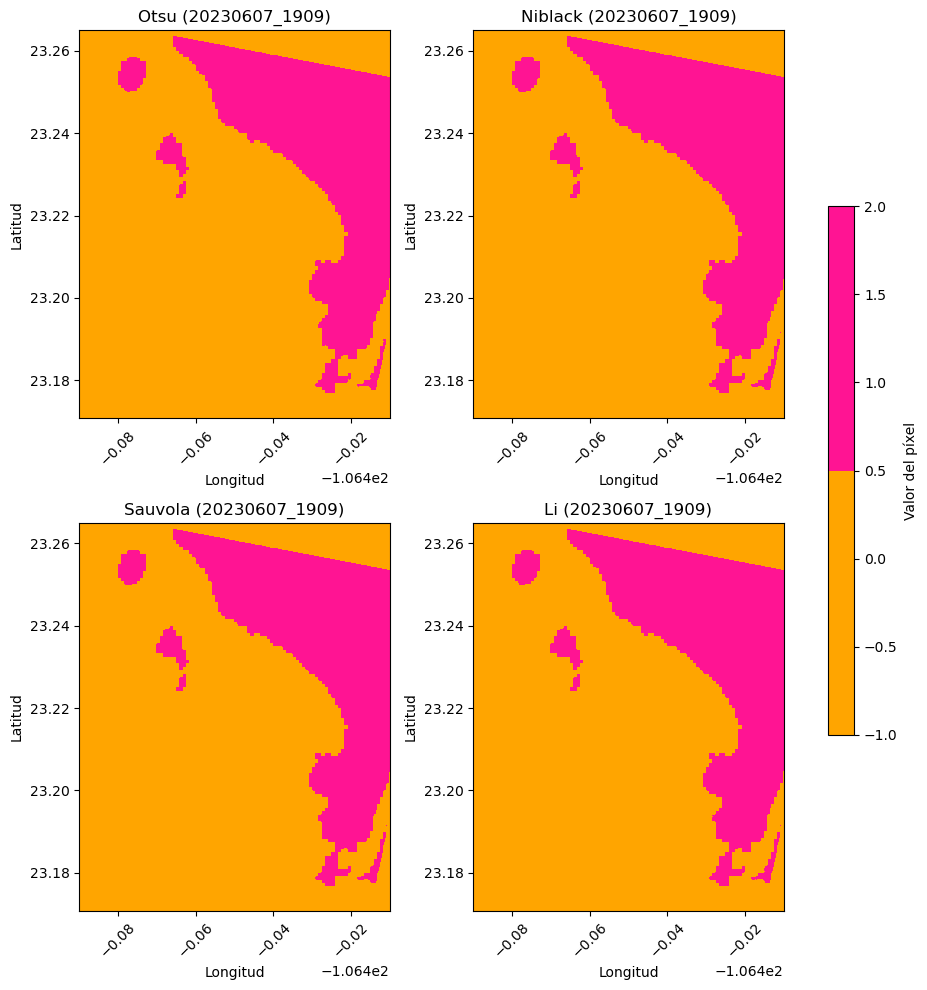

Guardando producto corregido: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\20230607_1909_flood_otsu_corrected.tif
Guardando producto corregido: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\20230607_1909_flood_niblack_corrected.tif
Guardando producto corregido: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\20230607_1909_flood_sauvola_corrected.tif
Guardando producto corregido: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\thresholdmzt\6_junio\20230607_1909_flood_li_corrected.tif


In [7]:
# 8. Umbralización (Método Sauvola) : waterDetectionBinarization [product]
print("Performing water detection...")
#waterDetection = clf.waterDetectionBinarization(textura, sentinel_1_path, output_directory)
productos_binarios = clf.WDBThreshold(
    textura=textura,
    sentinel_1_path=sentinel_1_path,
    output_directory=output_directory,
    window_size=31,
    k=0.2,     # extra param para Niblack/Sauvola
    r=None     # extra param para Sauvola
)

from coastalcf.geometricCorrection import corregir_valores_tierra
#productos_binarios = corregir_valores_tierra(productos_binarios)


# 9. Corrección geométrica: geometricCorrection [corrected]
print("Applying terrain correction to all thresholded products...")


productos_binarios_corrected = {}
for nombre, producto in productos_binarios.items():
    print(f" -> Corrigiendo: {nombre}")
    corregido = clf.geometricCorrection(producto, toPrint=True)
    if corregido is None:
        print(f"⚠️  No se pudo corregir el producto: {nombre}")
    else:
        productos_binarios_corrected[nombre] = corregido
        
        
        
# 10. Visualización en grid de productos corregidos
from coastalcf.wbplots import aplicar_correccion_y_grid
aplicar_correccion_y_grid(productos_binarios_corrected, output_directory, sentinel_id=sentinel_id)


for nombre, producto in productos_binarios_corrected.items():
    output_path = os.path.join(output_directory, f"{sentinel_id}_{nombre}_corrected.tif")  # o ".tif"
    print(f"Guardando producto corregido: {output_path}")
    #ProductIO.writeProduct(producto, output_path, "GeoTIFF")  # o "GeoTIFF" si prefieres tif

In [5]:
ProductIO.writeProduct(producto, output_path, "GeoTIFF")


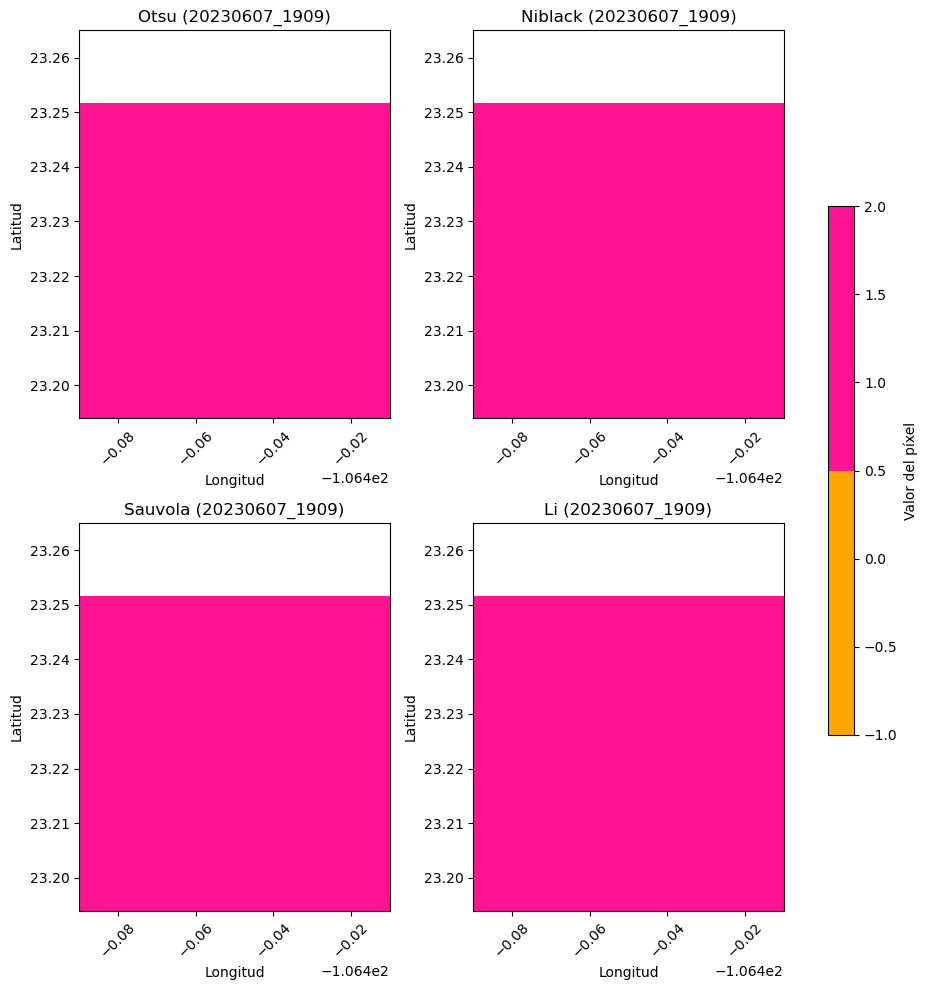

In [6]:
aplicar_correccion_y_grid(productos_binarios, output_directory, sentinel_id=sentinel_id)